[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ducis28/sg-dlfs4/blob/main/dlfs4_ch06.ipynb)

# 『ゼロから作るDeep Learning ❹ 強化学習編』

https://github.com/oreilly-japan/deep-learning-from-scratch-4

## 第6章 TD法

モンテカルロ法は，エピソードの「終わり」に辿り着かないと計算ができない。

連続タスクの場合，モンテカルロ法は適用できない。エピソードタスクであっても，エピソードを終えるのに時間がかかる場合は計算に時間がかかる。

TD法 (or TD学習; temporal difference learning) では，エピソードの終わりを待たずに一定の時間が進むごとに方策の評価と改善をおこなう。

TD法はモンテカルロ法（MC法）と動的計画法（DP法）を合わせたような方法。

In [ ]:
%pip install dezerogym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-4.git

Cloning into 'deep-learning-from-scratch-4'...
remote: Enumerating objects: 411, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 411 (delta 11), reused 9 (delta 7), pack-reused 391
Receiving objects: 100% (411/411), 1.02 MiB | 7.18 MiB/s, done.
Resolving deltas: 100% (235/235), done.


### 6.1 TD法による方策評価

- 収益: $G_t = R_t + \gamma \cdot G_{t+1}$
- 価値関数: $v_\pi(s) = \mathbb{E}\left[
  G_t \mid S_t = s \right] = \mathbb{E}\left[
  R_t + \gamma \cdot G_{t+1} \mid S_t = s \right]$

#### モンテカルロ法（MD法）の復習

各状態 $s$ から始まるシミュレーションを繰り返して収益の平均値を求める。

$$
V_n(s) = \frac{G^{(1)}+G^{(2)}+\cdots+G^{(n)}}{n}
$$

インクリメンタル方式だと

$$
V_n(s) = V_{n-1}(s) + \frac{1}{n}\left\{G^{(n)}-V_{n-1}(s)\right\}
$$

固定値 $\alpha$ 方式だと

$$
V_n(s) = V_{n-1}(s) + \alpha\left\{G^{(n)}-V_{n-1}(s)\right\}
$$

#### 動的計画法（DP法）の復習

まずベルマン方程式

$$
\begin{align*}
v_\pi(s)
&= \mathbb{E}_\pi\left[ G_t \mid S_t = s \right]
\\
&= \mathbb{E}_\pi\left[ R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \cdots \mid S_t = s \right]
\\
&= \mathbb{E}_\pi\left[ R_t + \gamma G_{t+1} \mid S_t = s \right]
\\
&= \mathbb{E}_\pi\left[ R_t \mid S_t = s \right]
   + \gamma \mathbb{E}\left[ G_{t+1} \mid S_t = s \right]
\\
&= \sum_{a,s'} \pi(a\mid s) \cdot p(s'\mid s,a) \cdot \left\{ r(s,a,s') + \gamma \cdot v_\pi(s') \right\}
\end{align*}
$$

これを更新式にする。

$$
\begin{align*}
V_{k+1}(s)
&= \sum_{a,s'} \pi(a\mid s) \cdot p(s'\mid s,a) \cdot \left\{ r(s,a,s') + \gamma \cdot V_k(s') \right\}
\end{align*}
$$


MC法では，$V_\pi(s)$ を $G_t$ に近づけるように更新する。$\alpha$ は更新の程度を表す（$\alpha=0$ なら全く更新せず，$\alpha=1$ なら $G_t$ に完全に一致させる）。$\alpha$ のことを学習率とよぶこともあるらしい。

DP法では，次の状態における価値関数 $V_\pi(s')$ を使って 今の状態における価値関数 $V_\pi(s)$ を更新する。

#### 6.1.1 TD法の導出

$$
\begin{align*}
v_\pi(s)
&=
\sum_{a,s'} \pi(a\mid s) \cdot p(s'\mid s,a) \cdot \left\{ r(s,a,s') + \gamma \cdot v_\pi(s') \right\}
\\
&=
\mathbb{E}_\pi\left[ R_t + \gamma \cdot v_\pi(S_{t+1}) \mid S_t = s \right]
\end{align*}
$$

TD法では $R_t + \gamma \cdot v_\pi(S_{t+1})$ をサンプルデータから近似する。

$$
V'_\pi(S_t)
=
V_\pi(S_t)
+ \alpha \cdot \left\{
  R_t + \gamma \cdot V_\pi(S_{t+1}) - V_\pi(S_t)
\right\}
$$

#### 6.1.2 MC法と TD 法の比較

MC法では $G_t$ をサンプルしたが，TD法では $R_t + \gamma G_{t+1}$ をサンプルする。

$$
V'(s) = V(s) + \alpha\left\{R^{(n)}+\gamma V(s')-V(s)\right\}
$$

別の表記によれば，状態価値関数の更新式は

$$
V'_\pi(S_t) = V_\pi(S_t) + \alpha\left\{R_t+\gamma V_\pi(S_{t+1})-V_\pi(S_t)\right\}
$$

この更新式における

$$
R_t+\gamma V_\pi(S_{t+1})
$$

を **TD ターゲット (TD target)** とよぶ。
また，

$$
R_t + \gamma V_\pi(S_{t+1}) - V_\pi(S_t)
$$

を **TD 誤差 (TD error)** とよぶ。

#### 6.1.3 TD法の実装

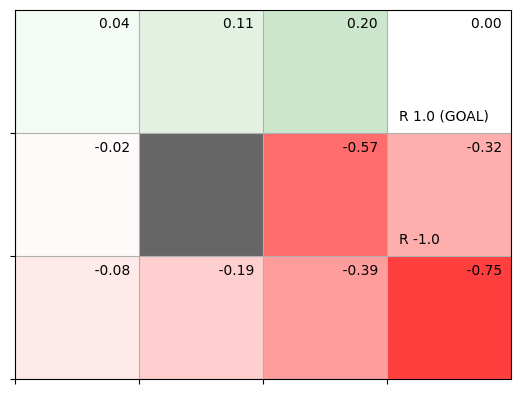

In [ ]:
from collections import defaultdict
import numpy as np
from dezerogym.gridworld import GridWorld


class TdAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.01
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def eval(self, state, reward, next_state, done):
        next_V = 0 if done else self.V[next_state]
        target = reward + self.gamma * next_V
        self.V[state] += (target - self.V[state]) * self.alpha


env = GridWorld()
agent = TdAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.eval(state, reward, next_state, done)
        if done:
            break
        state = next_state

env.render_v(agent.V)

MC法ではゴールにたどり着いたときに eval を呼ぶ。

TD法では，毎回 eval を呼ぶ。

### 6.2 SARSA

TD 法には主に 2 種類の手法がある。

1つはオンポリシーの SARSA，もう1つはオフポリシーの Q learning である。

本節では，まず SARSA を扱う。

行動価値関数 $Q_\pi(S_t,A_t)$ における TD 法の更新式は

$$
Q'_\pi(S_t,A_t)
=
Q_\pi(S_t,A_t)
+ \alpha \left\{ R_t + \gamma Q_\pi(S_{t+1},A_{t+1}) - Q_\pi(S_t,A_t) \right\}
$$

オンポリシーの場合，挙動方策とターゲット方策が一致する。
このとき，単純な greedy 法を用いると探索の余地がなくなり方策改善につながらないため，確率的に探索を混ぜる ε-greedy 法などを用いる。

$\varepsilon$ greedy 法によって，以下のように方策を定める

$$
\pi'(A_t\mid S_t)
=
\begin{cases}
\displaystyle\mathop{\rm argmax}_a\;Q_\pi(S_t,a) & \text{$1-\varepsilon$の確率}
\\
\text{ランダムな行動} & \text{$\varepsilon$の確率}
\end{cases}
$$

- 「評価」フェーズ: $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ の値を更新式に代入して $Q_\pi(s,a)$ を更新する
- 「改善」フェーズ: $\varepsilon$ greedy 法にしたがって $\pi(a\mid S_t)$ を更新する

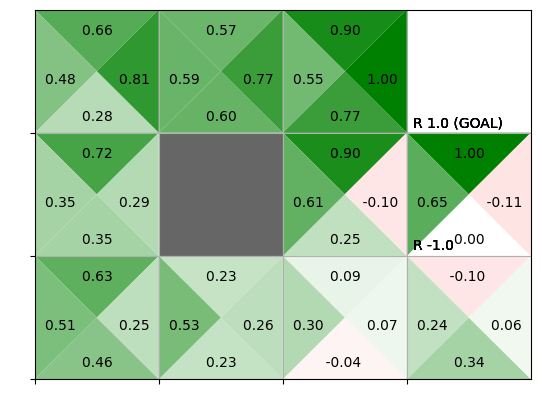

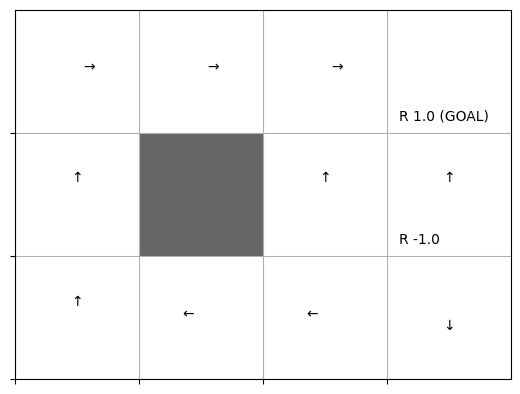

In [ ]:
#@title 6.2.2 SARSAの実装

from collections import deque


# utility functions (common functions)
def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes) == 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))
    selected = np.random.choice(idxes)
    return selected

def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(qs)  # OR np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


class SarsaAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        next_q = 0 if done else self.Q[next_state, next_action]

        target = reward + self.gamma * next_q
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        self.pi[state] = greedy_probs(self.Q, state, self.epsilon)


env = GridWorld()
agent = SarsaAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

env.render_q(agent.Q)

### 6.3 方策オフ型のSARSA

#### 6.3.1 方策オフ型と重点サンプリング

前節では方策オン型の SARSA を実装した。

次に方策オフ型の「Q 学習」へ進むのもよいが，いったん「方策オフ型の SARSA」をはさむ。

ポイント

- 挙動方策とターゲット方策は似ている方が良い（結果が安定する）
  - たとえば挙動方策は ε-greedy 法，ターゲット方策は greedy 法とする。
- 2 つの異なる方策を反映させるため，重点サンプリング（第5.5.2節参照）を用いる。

行動価値関数 $Q_\pi(S_t,A_t)$ の更新を考える。SARSA による更新式（第 6.2 節参照）は次の通り:

$$
Q'_\pi(S_t,A_t)
=
Q_\pi(S_t,A_t)
+ \alpha \left\{ R_t + \gamma Q_\pi(S_{t+1},A_{t+1}) - Q_\pi(S_t,A_t) \right\}
$$

重点サンプリングとは，$\mathbb{E}_\pi[x]$ を $\mathbb{E}_b[x\rho(x)]$，$\rho(x)=\frac{\pi(x)}{b(x)}$ に置き換えてサンプリングをおこなうものであった。

ここでは，

$$
\begin{align*}
& \text{sampling: } A_{t+1} \sim \pi
\\
& Q'_\pi(S_t,A_t)
=
Q_\pi(S_t,A_t)
+ \alpha \left\{ R_t + \gamma Q_\pi(S_{t+1},A_{t+1}) - Q_\pi(S_t,A_t) \right\}
\end{align*}
$$

を

$$
\begin{align*}
& \text{sampling: } A_{t+1} \sim b
\\
& Q'_\pi(S_t,A_t)
=
Q_\pi(S_t,A_t)
+ \alpha \left\{ \rho\left(R_t + \gamma Q_\pi(S_{t+1},A_{t+1})\right) - Q_\pi(S_t,A_t) \right\}
\end{align*}
$$

に置き換える。ただし，

$$
\rho = \frac{\pi(A_{t+1}\mid S_{t+1})}{b(A_{t+1}\mid S_{t+1})}
$$

#### 6.3.2 方策オフ型の SARSA の実装

- https://github.com/oreilly-japan/deep-learning-from-scratch-4/blob/master/ch06/sarsa_off_policy.py

In [ ]:
class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        # 一様な確率で行動を選択する
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        # ターゲット方策（デフォルトでは一様分布）
        self.pi = defaultdict(lambda: random_actions)
        # 挙動方策（デフォルトでは一様分布）
        self.b = defaultdict(lambda: random_actions)
        # 行動価値関数
        self.Q = defaultdict(lambda: 0)
        # 探索によって得た経験（最大長は２）
        self.memory = deque(maxlen=2)

    # 挙動方策にしたがって行動を一つ選択する
    def get_action(self, state):
        # ①状態 state における行動確率分布を挙動方策にしたがって取得する
        action_probs = self.b[state]
        # 行動の候補リストを取得する
        actions = list(action_probs.keys())
        # 行動の確率分布（確率のリスト）
        probs = list(action_probs.values())
        # 確率分布にしたがって行動を一つ選択する
        return np.random.choice(actions, p=probs)

    # 経験をリセットする
    def reset(self):
        # 探索によって得た経験を忘れる（消去する）
        self.memory.clear()

    #
    def update(self, state, action, reward, done):
        # 今回の探索によって得た経験を１つ追加する
        self.memory.append((state, action, reward, done))
        # 経験が２個未満（つまり１個）ならまだ何もせず次へ進む
        if len(self.memory) < 2:
            return

        # 経験が２個以上（最大長は２なので，つまり２個）ならば・・・
        # 古い方の記録
        state, action, reward, done = self.memory[0]
        # 新しい方（ついさきほど追加した）記録
        next_state, next_action, _, _ = self.memory[1]

        if done:
            # エピソードの終わりに達したら，
            next_q = 0  # これ以上報酬はもらえない
            rho = 1     # エピソードが終わったのでもう方策は変わらないため
        else:
            # まだエピソードの途中なら，
            next_q = self.Q[next_state, next_action]
            # ②重み ρ を求める
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]

        # ③ρによる TD ターゲットの補正
        target = rho * (reward + self.gamma * next_q)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        # ④それぞれの方策を改善する
        self.pi[state] = greedy_probs(self.Q, state, 0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

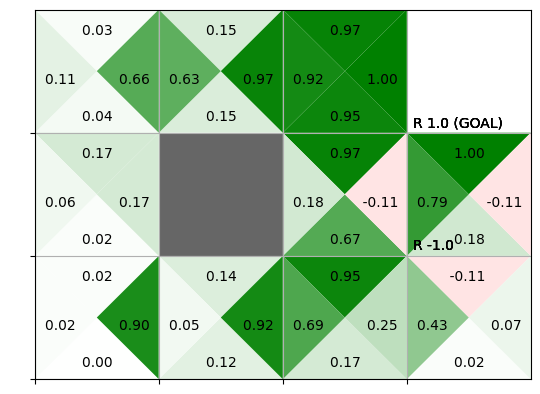

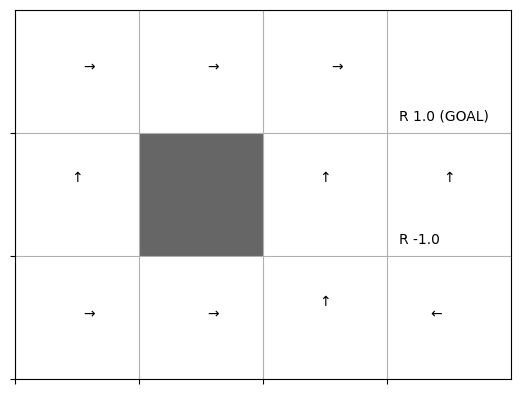

In [ ]:
# 環境とエージェントを生成する
env = GridWorld()
agent = SarsaOffPolicyAgent()

# 1万回のエピソードを試す
episodes = 10000
for episode in range(episodes):
    # 環境とエージェントをリセットする
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

env.render_q(agent.Q)

### 6.4 Q学習

方策オフ型の SARSA では，重点サンプリングを用いる。
重点サンプリングは不安定になりやすい。
特に 2 つの方策の確率分布が異なるほど ρ が大きく変動し不安定になる。

Q 学習の特徴は
- TD 法
- 方策オフ型
- 重点サンプリングを使わない

以下のように関連付けることができる。

ベルマン方程式　→　SARSA

ベルマン最適方程式　→　Q 学習

以下では，この関係の意味を順に確認する。

#### 6.4.1 ベルマン方程式と SARSA

ベルマン方程式（第 3.3.2 節，式 3.14）

$$
q_\pi(s,a)
= \sum_{s'} p(s'\mid s,a) \cdot \Bigl\{
   r(s,a,s') + \gamma \cdot \sum_{a'} \pi(a'\mid s') \cdot q_\pi(s',a')
   \Bigr\}
$$

SARSA

$$
Q'_\pi(S_t,A_t)
=
Q_\pi(S_t,A_t)
+ \alpha \cdot
\left\{
R_t + \gamma \cdot Q_\pi(S_{t+1},A_{t+1}) - Q_\pi(S_t,A_t)
\right\}
$$

ベルマン方程式には Σ を含む。つまり，次のあらゆる状態 $s'$ と次のあらゆる行動 $a'$ をすべて考慮する。

一方で SARSA の更新式には Σ が含まれない。次の状態と次の行動は，サンプリングによって得られる 1 組の値だけを用いる。

#### 6.4.2 ベルマン最適方程式と Q 学習

ベルマン最適方程式（第 3.4.2 節，式 3.18）

$$
q_*(s,a) = \sum_{s'} p(s'\mid s,a) \cdot \left\{ r(s,a,s') + \gamma \cdot \max_{a'} q_*(s',a') \right\}
$$

Q 学習（ベルマン最適方程式のサンプリング版）

$$
Q'(S_t,A_t) = Q(S_t,A_t) + \alpha \cdot \left\{ R_t + \gamma \cdot \max_{a} Q(S_{t+1},a) - Q(S_t,A_t) \right\}
$$

SARSA と比較すると，次の行動 $A_{t+1}$ を 1 つサンプリングするのでなく，max をとる点に違いがある。$A_{t+1}$ をサンプリングしないので，重点サンプリング（ターゲット方策 $\pi$ と挙動方策 $b$ の違いを考慮する）を用いる必要はない。

#### 6.4.3 Q 学習の実装

In [ ]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        # 一様な確率で行動を選択する
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        # ターゲット方策（デフォルトでは一様分布）
        self.pi = defaultdict(lambda: random_actions)
        # 挙動方策（デフォルトでは一様分布）
        self.b = defaultdict(lambda: random_actions)
        # 行動価値関数
        self.Q = defaultdict(lambda: 0)

    # 挙動方策にしたがって行動を一つ選択する
    def get_action(self, state):
        # ①状態 state における行動確率分布を挙動方策にしたがって取得する
        action_probs = self.b[state]
        # 行動の候補リストを取得する
        actions = list(action_probs.keys())
        # 行動の確率分布（確率のリスト）
        probs = list(action_probs.values())
        # 確率分布にしたがって行動を一つ選択する
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        if done:
            # エピソードの終わりに達したら，
            next_q_max = 0  # これ以上報酬はもらえない
        else:
            # まだエピソードの途中なら，
            # Q関数が最大となる行動を選ぶ
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        # TD ターゲット
        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        # それぞれの方策を改善する
        self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

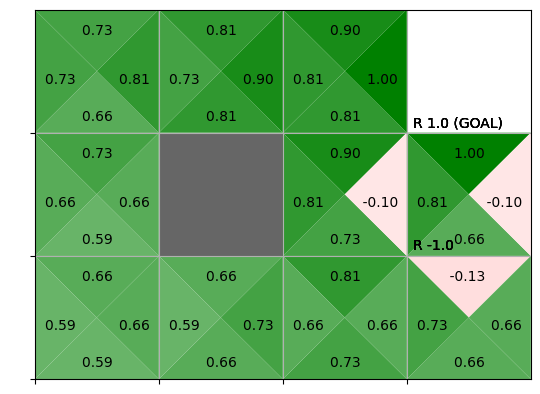

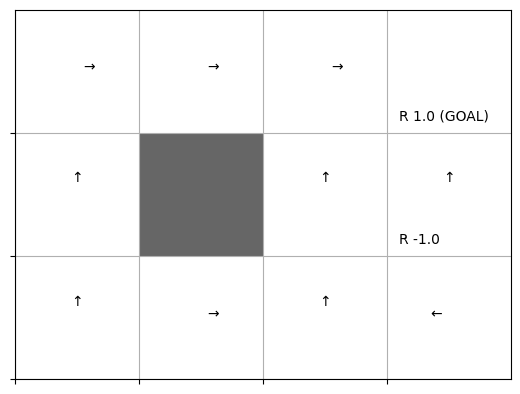

In [ ]:
env = GridWorld()
agent = QLearningAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state

env.render_q(agent.Q)

### 6.5 分布モデルとサンプルモデル

#### 6.5.1 分布モデルとサンプルモデル

「5.1 モンテカルロ法の基礎」では，環境にかんする分布モデル・サンプルモデルの説明をした。エージェントについても同様に分布モデル・サンプルモデルを考えることができる。

「分布モデル」は内部に確率分布を持ち，その分布にしたがってサンプルを得ることができる。サンプルモデルは，サンプルが得られさえすればよく，内部に確率分布を持つ必要はない。

In [ ]:
from collections import defaultdict
import numpy as np

In [ ]:
### ランダムに行動するエージェントを「分布モデル」として実装する

class RandomAgent:
    def __init__(self):
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}  # 確率分布
        self.pi = defaultdict(lambda: random_actions)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)  # サンプリング

In [ ]:
### ランダムに行動するエージェントを「サンプルモデル」として実装する

class RandomAgent:
    def __init__(self):
        pass

    def get_action(self, state):
        return np.random.choice(4)  # サンプリング

#### 6.5.2 サンプルモデル版の Q 学習

クラス `QLearningAgent` について，

- `self.pi` は，実はどこからも参照されていないので，削除できる。
- `self.b` は `update()` で更新しなくてもよい。 `self.b` を利用するタイミング，つまり `get_action()` で更新すればよい。
  - 計算量は？

In [ ]:
#### サンプルモデル版 の Q 学習の実装

class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = [self.Q[state, a] for a in range(self.action_size)]
            return np.argmax(qs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

差分は以下の通り

In [ ]:
!diff -u --color deep-learning-from-scratch-4/ch06/q_learning{,_simple}.py

--- deep-learning-from-scratch-4/ch06/q_learning.py	2023-05-31 22:24:13.445643503 +0000
+++ deep-learning-from-scratch-4/ch06/q_learning_simple.py	2023-05-31 22:24:13.445643503 +0000
@@ -2,7 +2,6 @@
 from collections import defaultdict
 import numpy as np
 from common.gridworld import GridWorld
-from common.utils import greedy_probs
 
 
 class QLearningAgent:
@@ -11,17 +10,14 @@
         self.alpha = 0.8
         self.epsilon = 0.1
         self.action_size = 4
-
-        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
-        self.pi = defaultdict(lambda: random_actions)
-        self.b = defaultdict(lambda: random_actions)
         self.Q = defaultdict(lambda: 0)
 
     def get_action(self, state):
-        action_probs = self.b[state]
-        actions = list(action_probs.keys())
-        probs = list(action_probs.values())
-        return np.random.choice(actions, p=probs)
+        if np.random.rand() < self.epsilon:
+            return np.random.choice(self.action_size)
+   

事象からはニューラルネットワークを用いて Q 学習を実装する。その際は，ここで示したサンプルモデルの実装をベースとする。

### 6.6 まとめ

TD法は，モンテカルロ法と動的計画法を組み合わせたような手法である。
モンテカルロ法では，エピソードの終わりまで辿り着いてから価値関数を更新するのに対して，TD法は「今」と「次」の情報だけを用いて価値関数を更新する。そのため，更新を速くおこえると期待できる。

TD 法を用いる方策制御には， **SARSA** と **Q学習** の 2 種類がある。

SARSA は一般的には方策オン型（オンポリシー）だが，方策オフ型へ拡張することもできる。

Q学習は方策オフ型（オフポリシー）でありながら，重点サンプリングを使わずに Q 関数を更新する。


## メモ

- 書籍 p.177 式 (6.11) は誤り？
  - 左辺 $\pi(a\mid s)$ は確率，右辺は action
  - $\mu(S_t)$ かな？少し違う気もする。